## Util Functions and Library Imports

In [3]:
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import math
import numpy as np
import time
from scipy.stats import logistic

test_result = {}
def read_json(file_name):
    with open(file_name, "r") as file:
        obj = json.load(file)
    return obj

## Creation of drone objects
#### Python function to simulate and save a scalable static scenario of drone data

In [2]:
def create_cds(n_drones):
    drones = []
    for i in range(n_drones):
        tier = random.choice([1, 2, 3, 4])
        energy = random.normalvariate(20, 2.5)
        packet_rate = random.normalvariate(200, 50)
        location = (random.uniform(-2000, 2000), random.uniform(-2000, 2000))
        drone = {
            "id": i + 1,
            "tier": tier,
            "energy": energy,
            "packet_rate": packet_rate,
            "location": location,
        }
        drones.append(drone)

    file_name = f"drone_sim_{n_drones}.json"
    with open(file_name, "w") as file:
        json.dump(drones, file, indent=2)

    print(f"Data for {n_drones} drones created and saved to {file_name}.")


## Configuring Controller State

Configure the standards of SLA for ZT grades, criticalities of drone tiers, enemy territory, respective ZT metric ranges for grades, and simulated CPU availability

In [63]:
controller_config = {
    "grade_network_sla": {
        'A': 1200,
        'B': 1000,
        'C': 800,
        'D': 600,
        'E': 400
    },
    "tier_criticality": {
        1: 1.5,
        2: 1.25,
        3: 1,
        4: 0.8
    },
    "enemy_center" : [-900, 200],
    "enemy_radius": 400,
    "available_cpu_cycles_billion": 3,
    "zt_score_grade": {
        'A': [80, 150],
        'B': [50, 80],
        'C': [30, 50],
        'D': [15, 30],
        'E': [0, 15]
    },
    "cooldown_period": 60
}
with open('controller_config.json', "w") as file:
    json.dump(controller_config, file, indent=2)


## Simulation of attack history

Defining a conditional proportionality function for attack outcome distribution

In [4]:
def conditional_distribution(delta, threshold):
    if delta <= threshold:
        # Linear increase up to 0.5 until the threshold
        slope = 0.5 / threshold
        return slope * delta
    else:
        # Faster exponential increase beyond the threshold
        k = 2.0  # Adjust the rate of exponential increase as needed
        return 0.5 + 0.5 * (1 - 2 ** (-k * (delta - threshold)))

Function to generate simulation data for attack history

In [5]:
def generate_attack_data(n):
    data = []

    capture_x = np.linspace(0, 5000, 5000)
    capture_truth_dist = logistic.cdf(capture_x, loc=1200, scale=500)
    flooder_x = np.linspace(0, 30, 30)
    flooder_truth_dist = logistic.cdf(flooder_x, loc=6, scale=2)
    faker_x = np.linspace(0, 300, 500)
    faker_truth_dist = logistic.cdf(faker_x, loc=80, scale=20)
    
    for _ in range(n):
        distance_delta = random.randint(0, 5000)
        packet_rate_delta = random.randint(0, 200)
        energy_delta = random.randint(0, 20)

        capture_truth_prob = conditional_distribution(distance_delta, 1000)
        # capture_truth_prob = capture_truth_dist[np.argmin(np.abs(capture_x - distance_delta))]
        is_capture = random.choices([True, False], weights=[capture_truth_prob, 1-capture_truth_prob])[0]

        flooder_truth_prob = conditional_distribution(packet_rate_delta, 50)
        # flooder_truth_prob = flooder_truth_dist[np.argmin(np.abs(flooder_x - packet_rate_delta))]
        is_flooder_attack = random.choices([True, False], weights=[flooder_truth_prob, 1-flooder_truth_prob])[0]

        faker_truth_prob = conditional_distribution(energy_delta, 6)
        # faker_truth_prob = faker_truth_dist[np.argmin(np.abs(faker_x - energy_delta))]
        is_faker_attack = random.choices([True, False], weights=[faker_truth_prob, 1-faker_truth_prob])[0]

        true_count = [is_faker_attack, is_flooder_attack, is_capture].count(True)
        if true_count == 3:
            attack_success = True
        elif true_count == 0:
            attack_success = False
        else:
            attack_success = random.choices([True, False], weights=[8/10, 2/10])[0]
        
        attack_info = {
            "distance_delta": distance_delta,
            "packet_rate_delta": packet_rate_delta,
            "energy_delta": energy_delta,
            "is_capture": is_capture,
            "is_flooder_attack": is_flooder_attack,
            "is_faker_attack": is_faker_attack,
            "attack_success": attack_success
        }

        data.append(attack_info)

    df = pd.DataFrame(data)
    file_name = f"attack_sim_data_{n}.csv"
    df.to_csv(file_name, index=False)

    print(f"{n} rows of attack data generated and saved to {file_name}.")

## Function to check proximity to enemy base and report danger

In [6]:
def eucliden_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def is_in_enemy_territory(my_location, enemy_center, enemy_radius):
    distance_to_enemy_center = eucliden_distance(enemy_center, my_location)

    return distance_to_enemy_center <= enemy_radius

## Bayesian Network Model to calculate Risk

In [7]:
def get_bn_risk(attack_data, cds_data, request, enemy_center, enemy_radius):
    
    global test_result
    energy_values = [drone["energy"] for drone in cds_data if drone["id"] != request['sourceDroneId']]
    average_energy = sum(energy_values) / len(energy_values)
    energy_delta = request['energy'] - average_energy if request['energy'] > average_energy else 0
    print(f'averageenergy: {average_energy}, energy_delta: {energy_delta}')
    fakerCPT = {}
    numerator = len(attack_data.query(f'(energy_delta >= {energy_delta - 3}) & (energy_delta <= {energy_delta + 3}) & (is_faker_attack == True)'))
    denominator = len(attack_data.query(f'(energy_delta >= {energy_delta - 3}) & (energy_delta <= {energy_delta + 3})'))
    if energy_delta > attack_data['energy_delta'].max():
        fakerCPT[True] = 0.99    
    elif energy_delta == 0 or numerator == 0:
        fakerCPT[True] = 0.01
    elif numerator/denominator == 1:
        fakerCPT[True] = 0.99    
    else:
        fakerCPT[True] = numerator / denominator
    fakerCPT[False] = 1 - fakerCPT[True]
    print(f'Faker prob: {fakerCPT[True]}')

    packet_rate_values = [drone["packet_rate"] for drone in cds_data if drone["id"] != request['sourceDroneId']]
    average_packet_rate = sum(packet_rate_values) / len(packet_rate_values)
    print(f'averagePacketRate: {average_packet_rate}')
    packet_rate_delta = request['packetRate'] - average_packet_rate if request['packetRate'] > average_packet_rate else 0
    print(f'packetRateDelta: {packet_rate_delta}')
    flooderCPT = {}
    numerator = len(attack_data.query(f'(packet_rate_delta >= {packet_rate_delta - 15}) & (packet_rate_delta <= {packet_rate_delta + 15}) & (is_flooder_attack == True)'))
    denominator = len(attack_data.query(f'(packet_rate_delta >= {packet_rate_delta - 15}) & (packet_rate_delta <= {packet_rate_delta + 15})'))
    if packet_rate_delta > attack_data['packet_rate_delta'].max():
        flooderCPT[True] = 0.99  
    elif packet_rate_delta == 0 or denominator == 0 or numerator == 0:
        flooderCPT[True] = 0.01
    elif numerator/denominator == 1:
        flooderCPT[True] = 0.99    
    else:
        flooderCPT[True] = numerator / denominator
    flooderCPT[False] = 1 - flooderCPT[True]
    print(f'Flooder prob: {flooderCPT[True]}')

    captureCPT = {}
    if is_in_enemy_territory(request['location'], enemy_center, enemy_radius):
        captureCPT[True] = 0.99
        distance, average_distance, distance_delta = 100, 100, 100
    else:
        distance_values = [eucliden_distance(drone["location"], (0, 0)) for drone in cds_data if drone["id"] != request['sourceDroneId']]
        average_distance = sum(distance_values) / len(distance_values)
        distance = eucliden_distance(request['location'], (0, 0))
        distance_delta = distance - average_distance if distance > average_distance else 0
        numerator =  len(attack_data.query(f'(distance_delta >= {distance_delta - 200}) & (distance_delta <= {distance_delta + 200}) & (is_capture == True)'))
        denominator = len(attack_data.query(f'(distance_delta >= {distance_delta - 200}) & (distance_delta <= {distance_delta + 200})'))
        print(f'distAvg: {average_distance}, distDelta: {distance_delta}')
        if distance_delta > attack_data['distance_delta'].max():
            captureCPT[True] = 0.99  
        elif distance_delta == 0 or denominator == 0 or numerator == 0:
            captureCPT[True] = 0.01
        elif numerator/denominator == 1:
            captureCPT[True] = 0.99    
        else:
            captureCPT[True] = numerator / denominator
    captureCPT[False] = 1 - captureCPT[True]
    print(f'capture prob: {captureCPT[True]}')

    risk = 0
    for perm in [list(p) for p in product([True, False], repeat=3)]:
        numerator = len(attack_data.query(f'(is_capture == {perm[2]}) & (is_flooder_attack == {perm[0]}) & (is_faker_attack == {perm[1]}) & (attack_success == True)'))
        denominator = len(attack_data.query(f'(is_capture == {perm[2]}) & (is_flooder_attack == {perm[0]}) & (is_faker_attack == {perm[1]})'))
        if denominator == 0:
            cond_prob = 0.01
        elif numerator == denominator:
            cond_prob = 0.99
        else:
            cond_prob = numerator / denominator
        
        risk += cond_prob * flooderCPT[perm[0]] * fakerCPT[perm[1]] * captureCPT[perm[2]]
    
    test_result_keys = ['srcDroneId', 'destDroneId', 'packetRate', 'energy', 'distance', 'packetRateAvg', 'energyAvg', 'distanceAvg', 'packetRateDelta', 'energyDelta', 'distanceDelta', 'flooderProb', 'fakerProb', 'captureProb', 'riskScore' ]
    test_result_values = [request['sourceDroneId'], request['destDroneId'], request['packetRate'], request['energy'], distance, average_packet_rate, average_energy, average_distance, packet_rate_delta, energy_delta, distance_delta, flooderCPT[True], fakerCPT[True], captureCPT[True], risk]
    test_result.update({k: v for k, v in zip(test_result_keys, test_result_values)})
    return risk

## Risk-based Zero Trust Scale

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_compute_easer(cpu_cycles):
    # Define the range of x values for the sigmoid function
    x_min = 0
    x_max = 10
    
    # Calculate the x value from CPU cycles within the defined range
    x = (cpu_cycles - x_min) / (x_max - x_min)
    
    # Calculate the corresponding y-axis value using the sigmoid function
    y = sigmoid(x)
    
    # Return the multiplier value (y-axis value)
    return y

In [23]:
def execute_zerotrust(drone_sim_file, attack_data_file, controller_config_file, request):
    start_time = time.time()
    global test_result
    controller_config = read_json(controller_config_file)
    drone_sim_data = read_json(drone_sim_file)
    attack_data = pd.read_csv(attack_data_file)
    risk = get_bn_risk(attack_data, drone_sim_data, request, controller_config['enemy_center'], controller_config['enemy_radius'])
    print(drone_sim_data)
    record = next((item for item in drone_sim_data if item.get('id') == request['destDroneId']), None)
    criticality = controller_config['tier_criticality'][str(record['tier'])]
        # criticality = controller_config[drone_sim_data[request['destDroneId']]]
    compute_easer = 1 if criticality >= 1.25 else get_compute_easer(controller_config['available_cpu_cycles_billion'])

    zt_metric = risk * compute_easer * criticality * 100 # ZT Metric formulation
    print(f'ZT Metric = {zt_metric}')
    grade_zt_range_map = controller_config['zt_score_grade']
    zt_grade = 'A' # Just a string assignment
    for grade in grade_zt_range_map.keys():
        print(grade)
        print(grade_zt_range_map[grade][0], grade_zt_range_map[grade][1]+1)
        if grade_zt_range_map[grade][0] <= zt_metric and zt_metric <= grade_zt_range_map[grade][1]:
            print(f'It is true for {grade}')
            zt_grade = grade
            break
    sla = controller_config['grade_network_sla'][zt_grade]

    test_result_keys = ['criticality', 'destDroneTier', 'avlCpuCycles', 'computeEaser', 'slaNetworkSpeed', 'networkSpeed', 'ztMetric', 'initZtGrade']
    test_result_values = [criticality, record['tier'], controller_config['available_cpu_cycles_billion'], compute_easer, sla, request['networkSpeed'], zt_metric, zt_grade]
    test_result.update({k: v for k, v in zip(test_result_keys, test_result_values)})

    if request['networkSpeed'] >= sla:
        pass
    elif request['networkSpeed'] >= sla * 0.8:
        print(f'The requesting drone satisfies only 80%% of initial grade-{zt_grade} SLA requirements. Downgrading.')
        zt_grade = chr(ord(zt_grade) + 1)
    else:
        print(f"The requesting drone's network speed doesn't comply to the SLA requirement of ZT Grade-{zt_grade}. Executing a deny policy until cool-down time for {controller_config['cooldown_period']}.")
        test_result['finalZtGrade'] = 'deny until cooldown'
        print(f'Execution Time: {time.time() - start_time}')
        return
    test_result['finalZtGrade'] = zt_grade
    print(f'Executing Grade-{zt_grade} Zero Trust Security policies.')
    print(f'Execution Time: {time.time() - start_time}')


## Attack Simulation

For 16 drones and 100 records of attack data

In [14]:
create_cds(16)
generate_attack_data(100)

Data for 16 drones created and saved to drone_sim_16.json.
100 rows of attack data generated and saved to attack_sim_data_100.csv.


In [64]:
request = {
    "sourceDroneId": 4,
    "destDroneId": 6,
    "networkSpeed": 1000,
    "energy": 24,
    "packetRate": 243, 
    "location": [36, 45]
}

In [65]:
execute_zerotrust('drone_sim_16.json', 'attack_sim_data_100.csv', 'controller_config.json', request)

averageenergy: 19.895151546004993, energy_delta: 4.104848453995007
Faker prob: 0.4642857142857143
averagePacketRate: 198.5645453058126
packetRateDelta: 44.4354546941874
Flooder prob: 0.6363636363636364
distAvg: 50.77170945207238, distDelta: 6.856408684823258
Hijack prob: 0.2
[{'id': 1, 'tier': 4, 'energy': 20.96628805833734, 'packet_rate': 156.78035690538843, 'location': [29.027118390824967, 37.92770228302297], 'network_speed': 2785.7655896899987}, {'id': 2, 'tier': 2, 'energy': 17.936288637315727, 'packet_rate': 203.74645729181591, 'location': [5.56989773103362, -21.43402713156489], 'network_speed': -319.7559623310981}, {'id': 3, 'tier': 2, 'energy': 16.784436688979852, 'packet_rate': 174.13200993741367, 'location': [26.499126579531534, 52.73790474503065], 'network_speed': 850.8129858138399}, {'id': 4, 'tier': 1, 'energy': 21.5330732588565, 'packet_rate': 103.63958378920027, 'location': [-17.954007727047397, -59.276709954808894], 'network_speed': 1472.2915667009358}, {'id': 5, 'tier':

# Write to File

In [23]:
file_name = 'test_results.csv'
print(len(test_result))
try:
    # Try reading the existing file
    existing_data = pd.read_csv(file_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    existing_data = pd.DataFrame()

# Convert the new data dictionary to a DataFrame
new_data_df = pd.DataFrame([test_result])

# Append the new data to the existing DataFrame
updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)

# Save the updated DataFrame to the CSV file
updated_data.to_csv(file_name, index=False)
print("Results saved to csv file.")

24
Results saved to csv file.


For 32 drones and 200 records of attack data

In [37]:
create_cds(32)
generate_attack_data(200)

Data for 32 drones created and saved to drone_sim_32.json.
200 rows of attack data generated and saved to attack_sim_data_200.csv.


In [73]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 7,
    "networkSpeed": 600,
    "energy": 43,
    "packetRate": 340, 
    "location": [109, 200]
}

In [74]:
execute_zerotrust('drone_sim_32.json', 'attack_sim_data_200.csv', 'controller_config.json', request)

averageenergy: 20.292433886918953, energy_delta: 22.707566113081047
Faker prob: 0.99
averagePacketRate: 201.0244788290192
packetRateDelta: 138.9755211709808
Flooder prob: 0.99
distAvg: 47.141018513760905, distDelta: 180.6329922951986
Hijack prob: 0.99
[{'id': 1, 'tier': 2, 'energy': 14.63317020904883, 'packet_rate': 213.62735557367438, 'location': [-10.843064390076762, 3.635819454770342], 'network_speed': 953.7663457032687}, {'id': 2, 'tier': 4, 'energy': 23.321103988299797, 'packet_rate': 207.32245504803922, 'location': [2.374468084971255, -54.488784139007464], 'network_speed': 3372.8400789042234}, {'id': 3, 'tier': 2, 'energy': 20.117600755355024, 'packet_rate': 193.87555823208427, 'location': [16.474097007900127, 50.38460066738344], 'network_speed': 386.9943405213188}, {'id': 4, 'tier': 4, 'energy': 17.871774090285843, 'packet_rate': 219.2077655905623, 'location': [46.24161250866179, 4.70395619043029], 'network_speed': 952.4103888912241}, {'id': 5, 'tier': 1, 'energy': 19.7051174362

For 160 drones and 1000 records of attack data

In [33]:
create_cds(160)
generate_attack_data(1000)

Data for 160 drones created and saved to drone_sim_160.json.
1000 rows of attack data generated and saved to attack_sim_data_1000.csv.


In [34]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 7,
    "networkSpeed": 600,
    "energy": 28,
    "packetRate": 300, 
    "location": [35, 30]
}

In [71]:
execute_zerotrust('drone_sim_160.json', 'attack_sim_data_1000.csv', 'controller_config.json', request)

averageenergy: 19.92529326657407, energy_delta: 8.07470673342593
Faker prob: 0.89419795221843
averagePacketRate: 198.80719391046125
packetRateDelta: 101.19280608953875
Flooder prob: 0.99
distAvg: 45.2892085192673, distDelta: 0.808513767197141
Hijack prob: 0.15602836879432624
[{'id': 1, 'tier': 2, 'energy': 17.64936002928799, 'packet_rate': 193.43708326478588, 'location': [22.79359507867666, -42.75787111489205], 'network_speed': 2080.9824662688866}, {'id': 2, 'tier': 3, 'energy': 24.60931720033348, 'packet_rate': 122.0547346731871, 'location': [6.50214980799872, -28.15786902497832], 'network_speed': 2381.7774782975266}, {'id': 3, 'tier': 1, 'energy': 23.000810996016433, 'packet_rate': 205.45619379157526, 'location': [34.65510047700646, -5.98115839072431], 'network_speed': 1522.995199195469}, {'id': 4, 'tier': 2, 'energy': 18.419956145121393, 'packet_rate': 142.93569231900332, 'location': [16.573778316432026, 4.142446092298854], 'network_speed': 1221.143852208925}, {'id': 5, 'tier': 3, '

For 1600 drones and 10000 records of attack data

In [67]:
create_cds(16000)
generate_attack_data(100000)

Data for 16000 drones created and saved to drone_sim_16000.json.
100000 rows of attack data generated and saved to attack_sim_data_100000.csv.


In [68]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 7,
    "networkSpeed": 600,
    "energy": 28,
    "packetRate": 300, 
    "location": [35, 30]
}

In [72]:
execute_zerotrust('drone_sim_16000.json', 'attack_sim_data_100000.csv', 'controller_config.json', request)

averageenergy: 19.98115063310496, energy_delta: 8.01884936689504
Faker prob: 0.890252528825069
averagePacketRate: 200.45689457925303
packetRateDelta: 99.54310542074697
Flooder prob: 0.99
distAvg: 53.86487373378983, distDelta: 0
Hijack prob: 0.01
[{'id': 1, 'tier': 1, 'energy': 15.986844581420613, 'packet_rate': 212.52354065530258, 'location': [0.75475703554185, 17.01198464117796], 'network_speed': 3371.5995634635105}, {'id': 2, 'tier': 4, 'energy': 19.07797426633087, 'packet_rate': 258.04706824189736, 'location': [-31.651111179922214, -38.64764725239512], 'network_speed': 1589.2705857301205}, {'id': 3, 'tier': 4, 'energy': 23.750321575166534, 'packet_rate': 269.50014773876546, 'location': [40.70707837195873, 59.15555431167229], 'network_speed': 2285.0501683692237}, {'id': 4, 'tier': 3, 'energy': 20.917387503911886, 'packet_rate': 199.14979112144735, 'location': [-55.02675638525479, -35.07132322982662], 'network_speed': 1090.213036200986}, {'id': 5, 'tier': 1, 'energy': 16.3666242779341

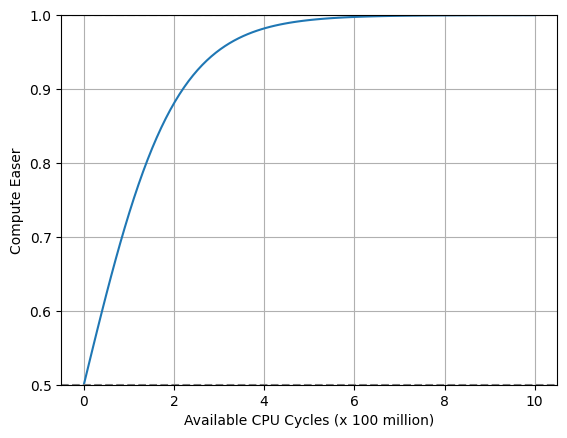

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(0, 10, 100)
y = sigmoid(x)

plt.plot(x, y)
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.axhline(y=1, color='gray', linestyle='--')
plt.xlabel('Available CPU Cycles (x 100 million)')
plt.ylabel('Compute Easer')
plt.title('')
plt.grid(True)

# Set the y-limits to start at 0.5
plt.ylim(0.5, 1.0)

plt.show()

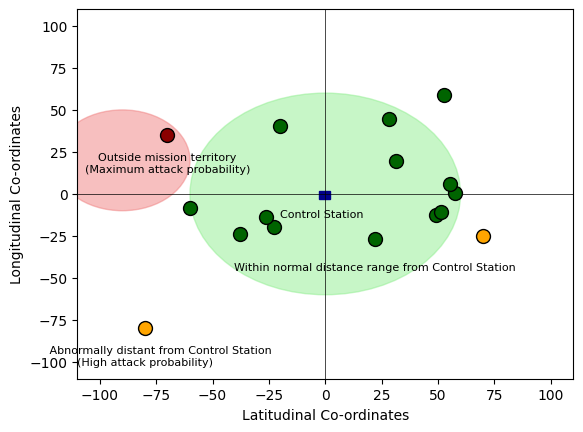

In [9]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Set axis limits
ax.set_xlim(-110, 110)
ax.set_ylim(-110, 110)

# Draw the transparent light green circle centered at the origin with radius 60
green_zone = plt.Circle((0, 0), 60, color='lightgreen', alpha=0.5)
ax.add_patch(green_zone)

# Draw the transparent light red circle at (-90, 20) with radius 30
circle = plt.Circle((-90, 20), 30, color='lightcoral', alpha=0.5)
ax.add_patch(circle)

# Draw the 16 thick points
points_data = [
    # Point in green zone
    {'x': 22, 'y': -27, 'color': 'darkgreen', 'label': 'Within normal distance range from Control Station'},

    # Point in uncolored zone
    {'x': -80, 'y': -80, 'color': 'orange', 'label': '         Abnormally distant from Control Station\n(High attack probability)'},

    # Point in the red zone (circular area)
    {'x': -70, 'y': 35, 'color': 'darkred', 'label': 'Outside mission territory\n(Maximum attack probability)'}
]

for point_data in points_data:
    ax.scatter(point_data['x'], point_data['y'], color=point_data['color'], s=100, zorder=10, edgecolors='black', linewidth=1)
    ax.annotate(point_data['label'], (point_data['x'], point_data['y']), fontsize=8, ha='center', va='center',
                textcoords="offset points", xytext=(0, -20), color='black', wrap=True)

# Set other points in the green zone
green_points = []
for _ in range(12):
    x = np.random.uniform(-60, 60)
    y = np.random.uniform(-60, 60)
    green_points.append({'x': x, 'y': y, 'color': 'darkgreen'})

for point_data in green_points:
    ax.scatter(point_data['x'], point_data['y'], color=point_data['color'], s=100, zorder=10, edgecolors='black', linewidth=1)

blip = plt.Rectangle((-3, -3), 5, 5, color='darkblue')
ax.add_patch(blip)
ax.text(-20, -15, 'Control Station', fontsize=8, ha='left', va='bottom', color='black')

# Set other points in the uncolored zone
uncolored_points = [
    {'x': 70, 'y': -25, 'color': 'orange'},
]

for point_data in uncolored_points:
    ax.scatter(point_data['x'], point_data['y'], color=point_data['color'], s=100, zorder=10, edgecolors='black', linewidth=1)

# Draw axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Set axis labels
ax.set_xlabel('Latitudinal Co-ordinates')
ax.set_ylabel('Longitudinal Co-ordinates')

# Show the plot
plt.show()


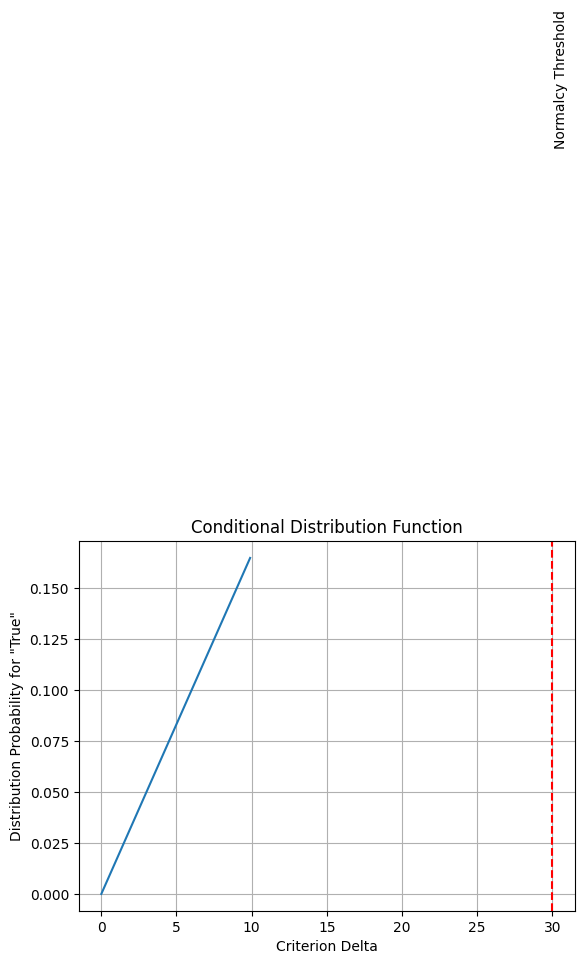

In [47]:
import matplotlib.pyplot as plt

def conditional_distribution(delta, threshold):
    if delta <= threshold:
        # Linear increase up to 0.5 until the threshold
        slope = 0.5 / threshold
        return slope * delta
    else:
        # Faster exponential increase beyond the threshold
        k = 2.0  # Adjust the rate of exponential increase as needed
        return 0.5 + 0.5 * (1 - 2 ** (-k * (delta - threshold)))

# def custom_logistic_cdf(x, mu, k):
#     return 1 / (1 + np.exp(-k * (x - mu)))

# Define the range of delta values for the graph
delta_values = [i / 10 for i in range(0, 100)]

# Define the threshold value
threshold_value = 30

# Calculate the corresponding y-values for each delta value
y_values = [conditional_distribution(delta, threshold_value) for delta in delta_values]

# Create the graph
plt.plot(delta_values, y_values)
plt.xlabel('Criterion Delta')
plt.ylabel('Distribution Probability for "True"')
plt.title('Conditional Distribution Function')

# Add a vertical line and text annotation for the "Normalcy Threshold"
plt.axvline(x=threshold_value, color='r', linestyle='--')
plt.text(threshold_value + 0.1, 0.4, 'Normalcy Threshold', rotation=90, va='center')

plt.grid(True)
plt.show()


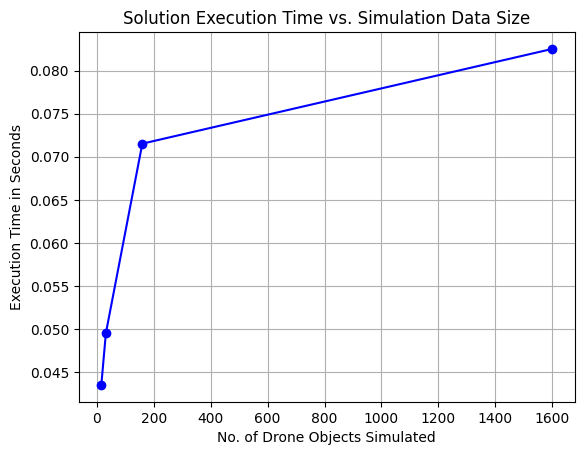

In [40]:
import matplotlib.pyplot as plt

# Data for x-axis and y-axis
x_values = [16, 32, 160, 1600]
y_values = [0.043511390686035156, 0.04952073097229004, 0.0715179443359375, 0.08251428604125977]

# Create the line graph
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('No. of Drone Objects Simulated')
plt.ylabel('Execution Time in Seconds')
plt.title('Solution Execution Time vs. Simulation Data Size')

# Show the plot
plt.grid(True)
plt.show()


## Simulation Automation for 100 requests

In [40]:
# Generate a list of dictionaries
data_list = []
file_name = 'test_results.csv'

for _ in range(100):
    req = {}
    req["sourceDroneId"] = np.random.choice(range(1, 33))
    req["destDroneId"] = np.random.choice(range(1, 33))
    req["networkSpeed"] = np.random.uniform(400, 1500)
    req["energy"] = np.random.uniform(0, 50)
    req["packetRate"] = np.random.uniform(180, 500)
    
    req["location"] = [np.random.uniform(-2500, 2500), np.random.uniform(-2500, 2500)]

    data_list.append(req)

# Print the generated list of dictionaries
for data_dict in data_list:
    print(data_dict)

for req in data_list:
    execute_zerotrust('drone_sim_32.json', 'attack_sim_data_200.csv', 'controller_config.json', req)
    print(len(test_result))
    try:
        # Try reading the existing file
        existing_data = pd.read_csv(file_name)
    except FileNotFoundError:
        # If the file doesn't exist, create a new DataFrame
        existing_data = pd.DataFrame()

    # Convert the new data dictionary to a DataFrame
    new_data_df = pd.DataFrame([test_result])

    # Append the new data to the existing DataFrame
    updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)

    # Save the updated DataFrame to the CSV file
    updated_data.to_csv(file_name, index=False)
    print("Results saved to csv file.")

{'sourceDroneId': 16, 'destDroneId': 23, 'networkSpeed': 477.95503913296164, 'energy': 25.007300254861914, 'packetRate': 384.73574526751656, 'location': [-1175.278999568214, -779.5232927464467]}
{'sourceDroneId': 11, 'destDroneId': 25, 'networkSpeed': 1067.2392673351014, 'energy': 22.322828038507225, 'packetRate': 461.908573045148, 'location': [192.76388808185675, -2070.664273842573]}
{'sourceDroneId': 7, 'destDroneId': 11, 'networkSpeed': 455.7520370734675, 'energy': 28.134226499522363, 'packetRate': 189.27629564839424, 'location': [2107.4288947781297, 1288.8048764576724]}
{'sourceDroneId': 6, 'destDroneId': 16, 'networkSpeed': 1043.890886405069, 'energy': 43.784889540905844, 'packetRate': 387.49559713022717, 'location': [726.162072081619, 394.89797085098144]}
{'sourceDroneId': 14, 'destDroneId': 12, 'networkSpeed': 1289.8436205744176, 'energy': 38.78322461895267, 'packetRate': 237.90059059630158, 'location': [1459.822175333266, 850.9477450218051]}
{'sourceDroneId': 7, 'destDroneId': 

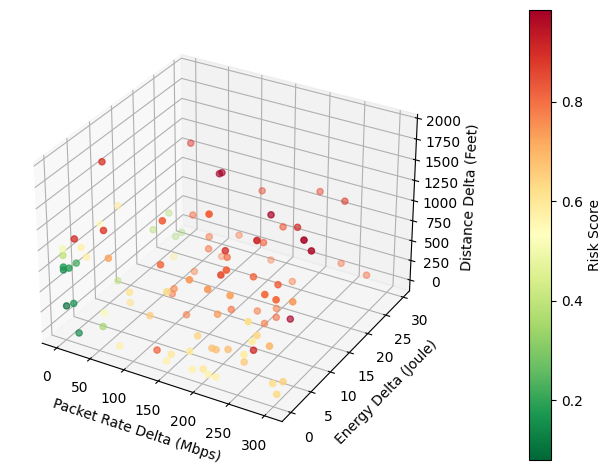

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('test_results.csv')

# Generate some sample data
input_var1 = data['packetRateDelta']
input_var2 = data['energyDelta']
input_var3 = data['distanceDelta']
outcome = data['riskScore']

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot with colors based on 'outcome'
scatter = ax.scatter(input_var1, input_var2, input_var3, c=(outcome), cmap='RdYlGn_r')

# Set labels for the axes
ax.set_xlabel('Packet Rate Delta (Mbps)')
ax.set_ylabel('Energy Delta (Joule)')
ax.set_zlabel('Distance Delta (Feet)')

# Add color bar to show the mapping of 'outcome' values to colors
cbar = plt.colorbar(scatter, pad=0.15)  # Adjust the 'pad' value to move the colorbar
cbar.set_label('Risk Score')

# Adjust layout to make room for the colorbar
plt.tight_layout()

# Show the plot
plt.show()


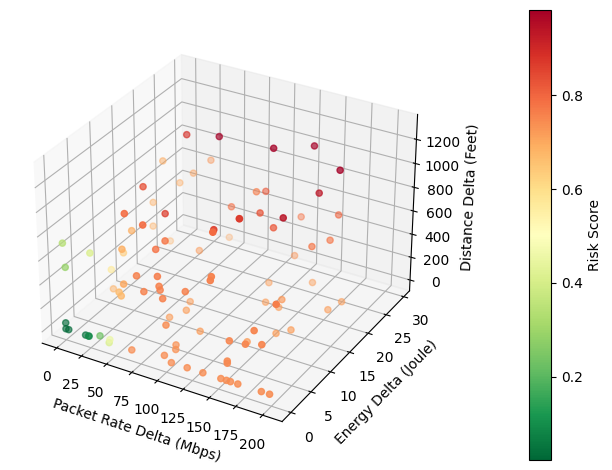

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('test_results.csv')

# Generate some sample data
input_var1 = data['packetRateDelta']
input_var2 = data['energyDelta']
input_var3 = data['distanceDelta']
outcome = data['riskScore']

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot with colors based on 'outcome'
scatter = ax.scatter(input_var1, input_var2, input_var3, c=(outcome), cmap='RdYlGn_r')

# Set labels for the axes
ax.set_xlabel('Packet Rate Delta (Mbps)')
ax.set_ylabel('Energy Delta (Joule)')
ax.set_zlabel('Distance Delta (Feet)')

# Add color bar to show the mapping of 'outcome' values to colors
cbar = plt.colorbar(scatter, pad=0.15)  # Adjust the 'pad' value to move the colorbar
cbar.set_label('Risk Score')

# Adjust layout to make room for the colorbar
plt.tight_layout()

# Show the plot
plt.show()


In [64]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 5,
    "networkSpeed": 1000,
    "energy": 28,
    "packetRate": 328, 
    "location": [320, 2424]
}
execute_zerotrust('drone_sim_32.json', 'attack_sim_data_200.csv', 'controller_config.json', request)
file_name = 'test_results.csv'
try:
    # Try reading the existing file
    existing_data = pd.read_csv(file_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    existing_data = pd.DataFrame()

# Convert the new data dictionary to a DataFrame
new_data_df = pd.DataFrame([test_result])

# Append the new data to the existing DataFrame
updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)

# Save the updated DataFrame to the CSV file
updated_data.to_csv(file_name, index=False)
print("Results saved to csv file.")

averageenergy: 19.917616456345538, energy_delta: 8.082383543654462
Faker prob: 0.9152542372881356
averagePacketRate: 197.3754602885369
packetRateDelta: 130.6245397114631
Flooder prob: 0.99
distAvg: 1517.5939590370824, distDelta: 927.4369201135266
capture prob: 0.4166666666666667
[{'id': 1, 'tier': 4, 'energy': 17.242280077831094, 'packet_rate': 239.38860369125345, 'location': [1177.0722321023181, -553.3113949782442]}, {'id': 2, 'tier': 4, 'energy': 19.62122651560415, 'packet_rate': 127.45774261697944, 'location': [409.1897027432133, -1011.3983745473085]}, {'id': 3, 'tier': 3, 'energy': 17.77659517275468, 'packet_rate': 171.29962368645792, 'location': [-1625.1322221867185, 1006.5753951726397]}, {'id': 4, 'tier': 4, 'energy': 19.04580114561693, 'packet_rate': 187.32101375160255, 'location': [-1088.150305814413, 1976.2102878036135]}, {'id': 5, 'tier': 3, 'energy': 21.681794131085184, 'packet_rate': 188.37333919934224, 'location': [253.06545916444475, 1427.9144925010796]}, {'id': 6, 'tier'

In [33]:
print(test_result)

{'srcDroneId': 3, 'destDroneId': 21, 'packetRate': 195, 'energy': 22, 'distance': 2525.8790549034607, 'packetRateAvg': 197.3754602885369, 'energyAvg': 19.917616456345538, 'distanceAvg': 1517.5939590370824, 'packetRateDelta': 0, 'energyDelta': 2.082383543654462, 'distanceDelta': 1008.2850958663782, 'flooderProb': 0.01, 'fakerProb': 0.2711864406779661, 'captureProb': 0.6, 'riskScore': 0.6102512179660448, 'criticality': 1.5, 'destDroneTier': 1, 'avlCpuCycles': 22, 'computeEaser': 1, 'slaNetworkSpeed': 1200, 'networkSpeed': 900, 'ztMetric': 91.53768269490672, 'initZtGrade': 'A', 'finalZtGrade': 'deny until cooldown'}


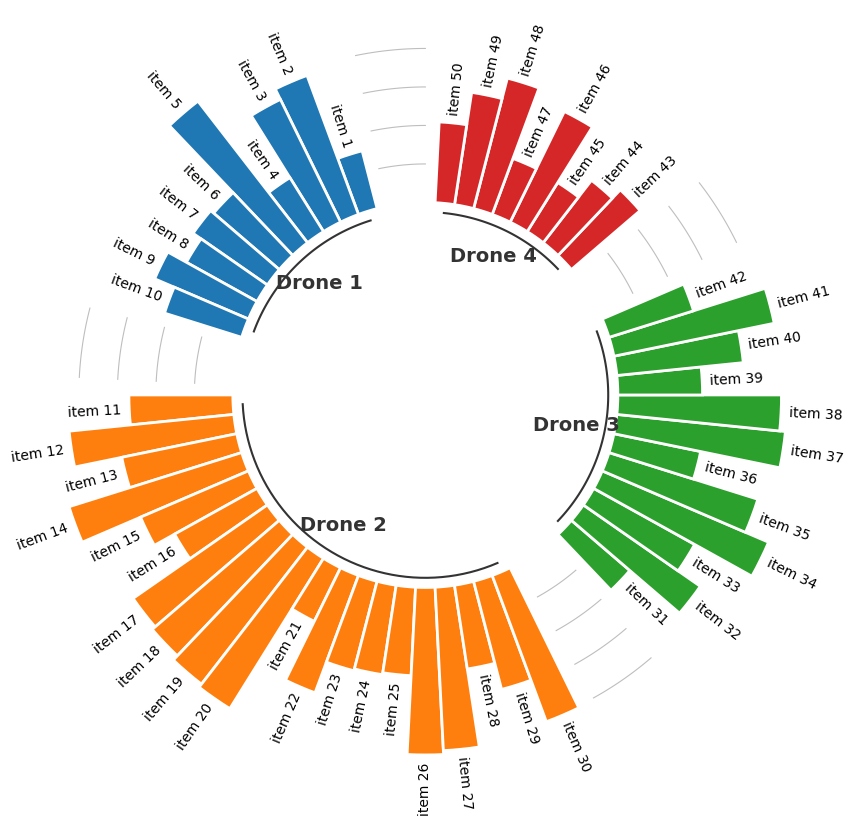

In [82]:
import matplotlib.pyplot as plt

# Your DataFrame and data setup
rng = np.random.default_rng(123)
df = pd.DataFrame({
    "name": [f"item {i}" for i in range(1, 51)],
    "value": rng.integers(low=30, high=100, size=50),
    "group": ["Drone 1"] * 10 + ["Drone 2"] * 20 + ["Drone 3"] * 12 + ["Drone 4"] * 8
})

df

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]
ANGLES_N = len(df) + 3 * len(np.unique(df["group"]))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
PAD = 3

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(np.pi / 2)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

ax.bar(
    ANGLES[IDXS], df["value"].values, width=WIDTH, color=COLORS,
    edgecolor="white", linewidth=2
)

def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        angle = angle
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor"
        )

add_labels(ANGLES[IDXS], df["value"].values, df["name"].values, np.pi / 2, ax)

offset = 0
for group, size in zip(np.unique(df["group"]), GROUPS_SIZE):
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=14,
        fontweight="bold", ha="center", va="center"
    )
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    for y in [20, 40, 60, 80]:
        ax.plot(x2, [y] * 50, color="#bebebe", lw=0.8)
    offset += size + PAD

plt.show()


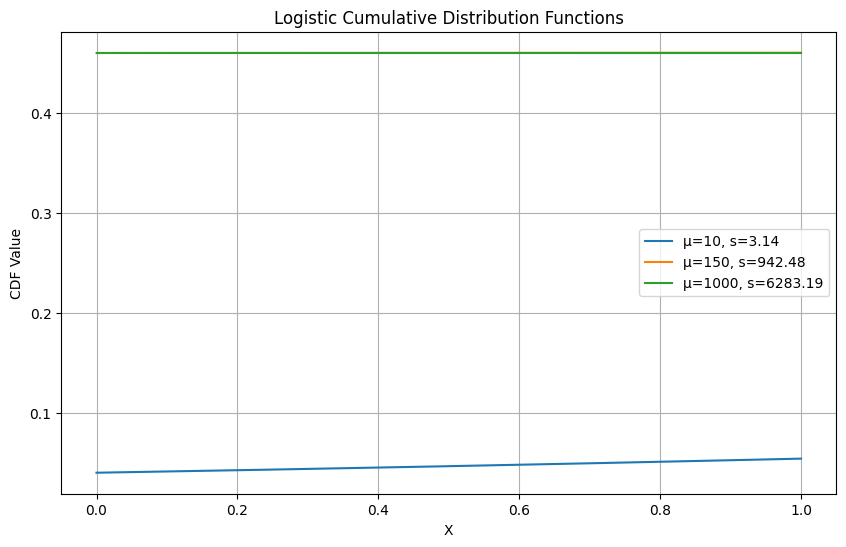

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the three distributions
params = [
    {'mu': 10, 's': np.pi},
    {'mu': 150, 's': np.pi * 300},
    {'mu': 1000, 's': np.pi * 2000}
]

# X values for plotting
x = np.linspace(0, 1, 500)

# Plotting the CDFs
plt.figure(figsize=(10, 6))
for param in params:
    cdf_values = logistic.cdf(x, loc=param['mu'], scale=param['s'])
    plt.plot(x, cdf_values, label=f"μ={param['mu']}, s={param['s']:.2f}")

plt.title("Logistic Cumulative Distribution Functions")
plt.xlabel("X")
plt.ylabel("CDF Value")
plt.legend()
plt.grid()
plt.show()


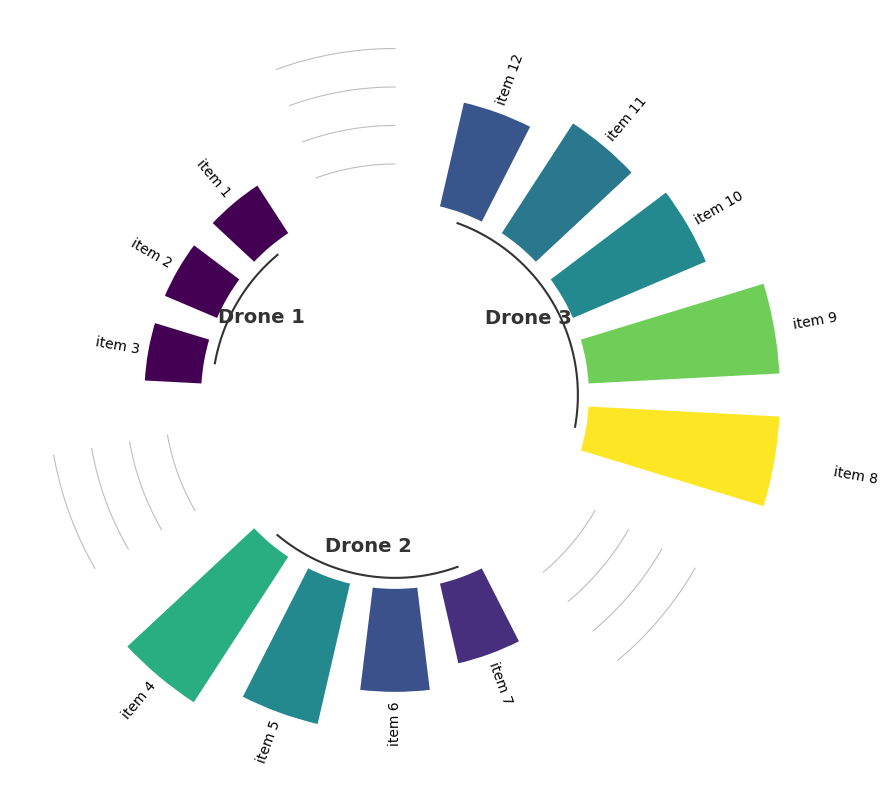

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Your DataFrame and data setup
rng = np.random.default_rng(123)
df = pd.DataFrame({
    "name": [f"item {i}" for i in range(1, 13)],
    "value": rng.integers(low=30, high=100, size=12),
    "group": ["Drone 1"] * 3 + ["Drone 2"] * 4 + ["Drone 3"] * 5
})

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]
ANGLES_N = len(df) + 3 * len(np.unique(df["group"]))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N - 3, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
PAD = 2

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(np.pi / 2)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

values = [
    30.8891291580071, 30.8891291580071, 30.8891291580071,
    91.53768269490672, 76.28140224575559, 54.93783604880481, 43.95026883904385,
    127.36046475731442, 106.13372063109536, 76.43746406884125, 69.41777684116023, 56.73380347232811
]

# Use different colors for each bar based on values
norm = plt.Normalize(min(values), max(values))
colors = plt.cm.viridis(norm(values))

ax.bar(
    ANGLES[IDXS], values, width=WIDTH*0.7, color=colors,
    edgecolor="white", linewidth=2
)

def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor"
        )

add_labels(ANGLES[IDXS], values, df["name"].values, np.pi / 2, ax)

offset = 0
for group, size in zip(np.unique(df["group"]), GROUPS_SIZE):
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=14,
        fontweight="bold", ha="center", va="center"
    )
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    for y in [20, 40, 60, 80]:
        ax.plot(x2, [y] * 50, color="#bebebe", lw=0.8)
    offset += size + PAD

plt.show()


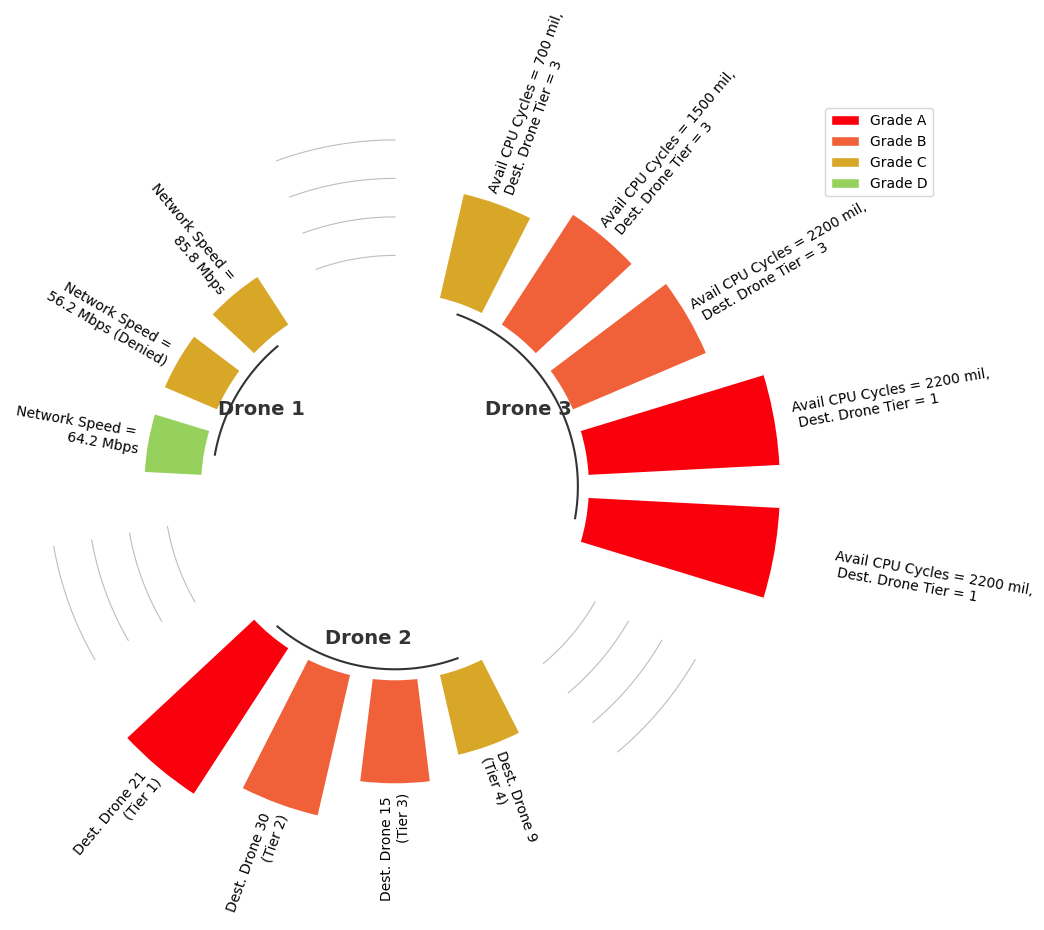

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Your DataFrame and data setup
rng = np.random.default_rng(123)
df = pd.DataFrame({
    "name": [f"item {i}" for i in range(1, 13)],
    "value": rng.integers(low=30, high=100, size=12),
    "group": ["Drone 1"] * 3 + ["Drone 2"] * 4 + ["Drone 3"] * 5
})

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]
ANGLES_N = len(df) + 3 * len(np.unique(df["group"]))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N - 3, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
PAD = 2

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(np.pi / 2)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

values = [
    30.8891291580071, 30.8891291580071, 30.8891291580071,
    91.53768269490672, 76.28140224575559, 54.93783604880481, 43.95026883904385,
    127.36046475731442, 106.13372063109536, 76.43746406884125, 69.41777684116023, 56.73380347232811
]

# Assign individual colors to each bar based on groups
colors = [
    '#d9a727', '#d9a727', '#95d15c', 
    '#f9000c', '#f0613a', '#f0613a', '#d9a727', 
    '#f9000c', '#f9000c', '#f0613a', '#f0613a', '#d9a727'
]

ax.bar(
    ANGLES[IDXS], values, width=WIDTH * 0.7, color=colors,
    edgecolor="white", linewidth=2
)

def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor"
        )

# add_labels(ANGLES[IDXS], values, df["name"].values, np.pi / 2, ax)

offset = 0
for group, size in zip(np.unique(df["group"]), GROUPS_SIZE):
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=14,
        fontweight="bold", ha="center", va="center"
    )
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    for y in [20, 40, 60, 80]:
        ax.plot(x2, [y] * 50, color="#bebebe", lw=0.8)
    offset += size + PAD

# Updated labels for the items with manual line breaks
new_labels = [
    "Network Speed = //85.8 Mbps",
    "Network Speed = //56.2 Mbps (Denied)",
    "Network Speed = //64.2 Mbps",
    "Dest. Drone 21 //(Tier 1)",
    "Dest. Drone 30 //(Tier 2)",
    "Dest. Drone 15 //(Tier 3)",
    "Dest. Drone 9 //(Tier 4)",
    "Avail CPU Cycles = 2200 mil,// Dest. Drone Tier = 1",
    "Avail CPU Cycles = 2200 mil,// Dest. Drone Tier = 1",
    "Avail CPU Cycles = 2200 mil,// Dest. Drone Tier = 3",
    "Avail CPU Cycles = 1500 mil,// Dest. Drone Tier = 3",
    "Avail CPU Cycles = 700 mil,// Dest. Drone Tier = 3"
]

# Manually format the line breaks using "\n"
formatted_labels = [label.replace('//', '\n') for label in new_labels]

# Call the add_labels function with the formatted labels
add_labels(ANGLES[IDXS], values, formatted_labels, np.pi / 2, ax)

# Adding legend
legend_elements = [
    Patch(facecolor='#f9000c', edgecolor='white', label='Grade A'),
    Patch(facecolor='#f0613a', edgecolor='white', label='Grade B'),
    Patch(facecolor='#d9a727', edgecolor='white', label='Grade C'),
    Patch(facecolor='#95d15c', edgecolor='white', label='Grade D')
]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))


plt.show()


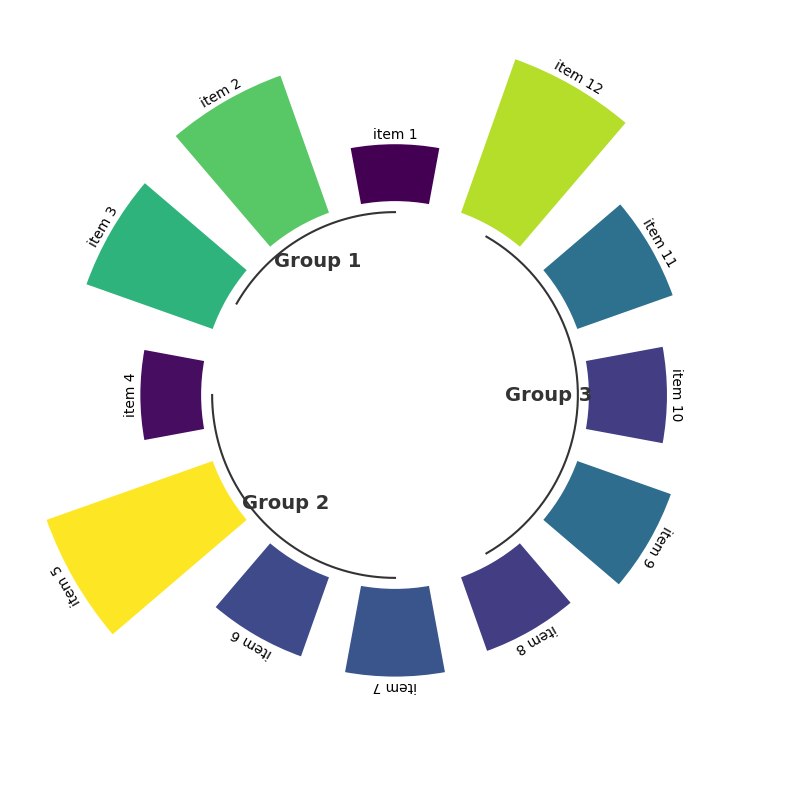

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your DataFrame and data setup
rng = np.random.default_rng(123)
df = pd.DataFrame({
    "name": [f"item {i}" for i in range(1, 13)],
    "value": rng.integers(low=30, high=100, size=12),
    "group": ["Group 1"] * 3 + ["Group 2"] * 4 + ["Group 3"] * 5
})

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]
GROUPS_COUNT = len(GROUPS_SIZE)
TOTAL_BARS = sum(GROUPS_SIZE)
PAD = 2

# Calculate the angles and widths
ANGLE_STEP = 2 * np.pi / TOTAL_BARS
ANGLES = np.linspace(0, 2 * np.pi, num=TOTAL_BARS, endpoint=False)
WIDTH = ANGLE_STEP * 0.7

# Calculate the indices for each group
offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset, offset + size))
    offset += size

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(np.pi / 2)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each bar based on values
norm = plt.Normalize(df["value"].min(), df["value"].max())
colors = plt.cm.viridis(norm(df["value"]))

ax.bar(
    ANGLES[IDXS], df["value"].values, width=WIDTH, color=colors,
    edgecolor="white", linewidth=2
)

def get_label_rotation(angle):
    return np.rad2deg(angle)

def add_labels(angles, values, labels, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha="center",
            va="center",
            rotation=get_label_rotation(angle),
            rotation_mode="anchor"
        )

add_labels(ANGLES[IDXS], df["value"].values, df["name"].values, ax)

offset = 0
for group, size in zip(np.unique(df["group"]), GROUPS_SIZE):
    x1 = np.linspace(ANGLES[offset], ANGLES[offset + size - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=14,
        fontweight="bold", ha="center", va="center"
    )
    x2 = np.linspace(ANGLES[offset], ANGLES[offset], num=50)  # Use the same angle for these lines
    for y in [20, 40, 60, 80]:
        ax.plot(x2, [y] * 50, color="#bebebe", lw=0.8)
    offset += size

plt.show()


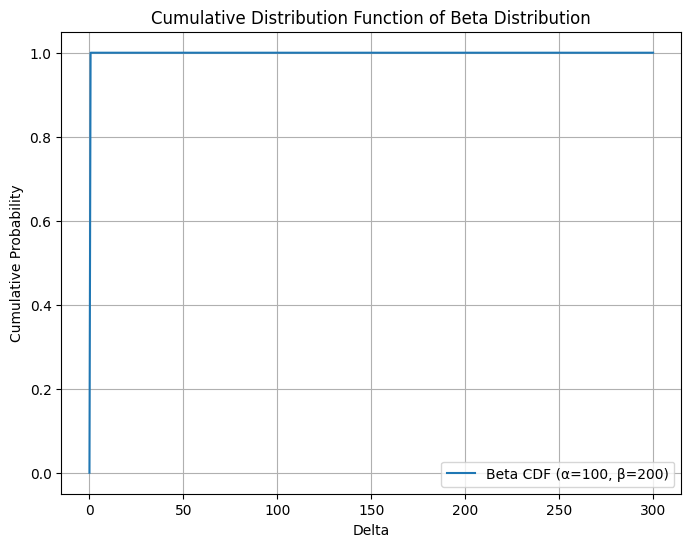

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Parameters for the Beta distribution
alpha = 100
beta_value = 200

# Generate values for the x-axis
x = np.linspace(0, 300, 500)

# Calculate the Beta CDF
cdf = beta.cdf(x, a=alpha, b=beta_value)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, cdf, label=f'Beta CDF (α={alpha}, β={beta_value})')
plt.xlabel('Delta')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Beta Distribution')
plt.legend()
plt.grid()
plt.show()


c:\Users\Reddy\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:2273: RuntimeWarning: overflow encountered in power
  return -sc.expm1(-pow(x, c))


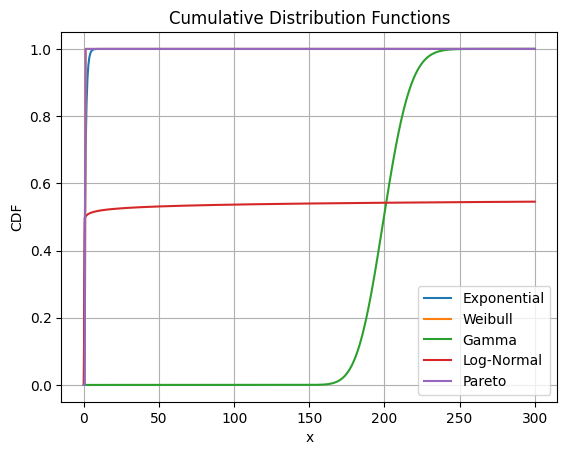

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, weibull_min, gamma, lognorm, pareto

x = np.linspace(0, 300, 500)  # Adjust the range as needed

# Calculate the CDF values for each distribution
exponential_cdf = expon.cdf(x)
weibull_cdf = weibull_min.cdf(x, c=200)
gamma_cdf = gamma.cdf(x, a=200)
lognorm_cdf = lognorm.cdf(x, s=50)
pareto_cdf = pareto.cdf(x, b=200)

# Plot the CDFs
plt.plot(x, exponential_cdf, label='Exponential')
plt.plot(x, weibull_cdf, label='Weibull')
plt.plot(x, gamma_cdf, label='Gamma')
plt.plot(x, lognorm_cdf, label='Log-Normal')
plt.plot(x, pareto_cdf, label='Pareto')
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Functions')
plt.legend()
plt.grid(True)
plt.show()


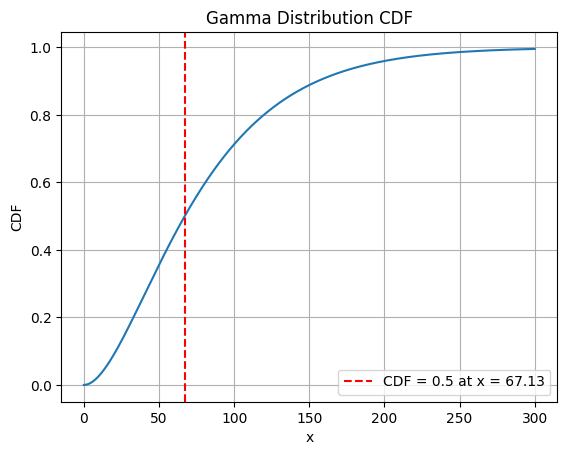

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Parameters for the gamma distribution
shape_parameter = 2  # Adjust the shape parameter as needed
scale_parameter = 40   # Adjust the scale parameter as needed

# Calculate the CDF values
x = np.linspace(0, 300, 1000)
gamma_cdf = gamma.cdf(x, a=shape_parameter, scale=scale_parameter)

# Find the x value where CDF is 0.5
x_at_cdf_0_5 = gamma.ppf(0.5, a=shape_parameter, scale=scale_parameter)

# Plot the CDF
plt.plot(x, gamma_cdf)
plt.axvline(x=x_at_cdf_0_5, color='r', linestyle='--', label=f'CDF = 0.5 at x = {x_at_cdf_0_5:.2f}')
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Gamma Distribution CDF')
plt.legend()
plt.grid(True)
plt.show()


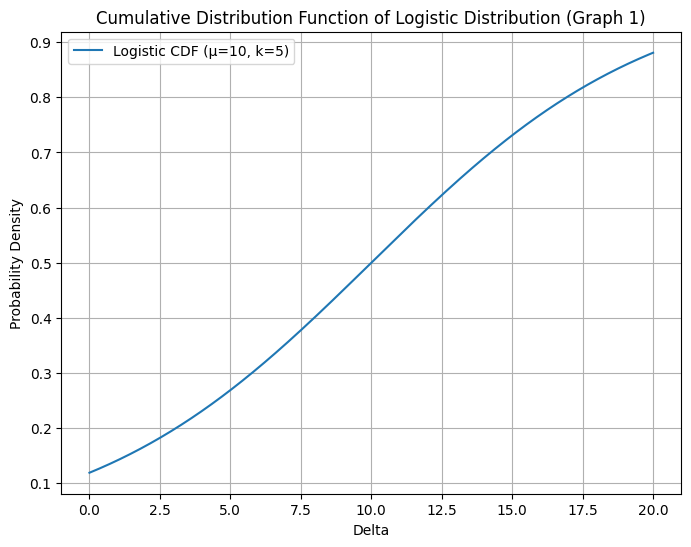

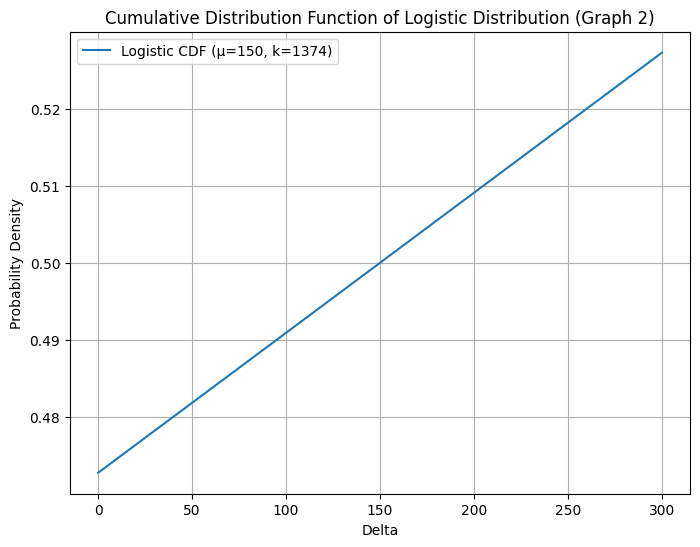

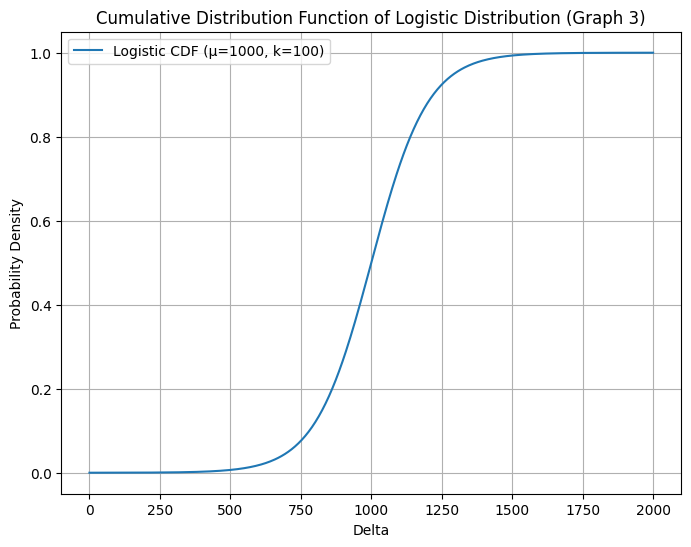

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the three distributions
params = [
    {'mu': 10, 'k': 5, 'domain': (0, 20)},
    {'mu': 150, 'k': 1374, 'domain': (0, 300)},
    {'mu': 1000, 'k': 100, 'domain': (0, 2000)}
]

# Generate values for the x-axis
x = {}
for param in params:
    x[param['domain']] = np.linspace(param['domain'][0], param['domain'][1], 500)

# Plotting each CDF on a separate graph with appropriate scales
for idx, param in enumerate(params, start=1):
    plt.figure(figsize=(8, 6))
    cdf = logistic.cdf(x[param['domain']], loc=param['mu'], scale=param['k'])
    plt.plot(x[param['domain']], cdf, label=f'Logistic CDF (μ={param["mu"]}, k={param["k"]})')

    plt.xlabel('Delta')
    plt.ylabel('Probability Density')
    plt.title(f'Cumulative Distribution Function of Logistic Distribution (Graph {idx})')
    plt.legend()
    plt.grid()
    plt.show()


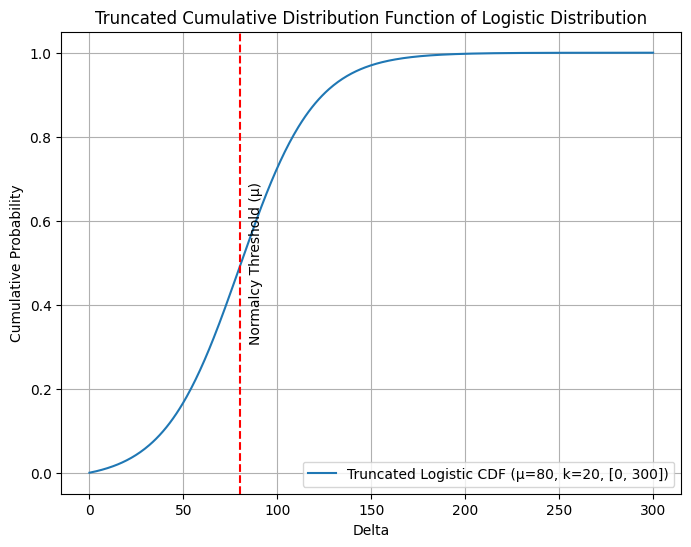

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the logistic distribution
mu = 80   # Mean
k = 20    # Steepness parameter
a = 00    # Lower truncation limit
b = 300   # Upper truncation limit

# Generate values for the x-axis within the truncated range
x_truncated = np.linspace(a, b, 500)

# Calculate the truncated logistic CDF
cdf_truncated = (logistic.cdf(x_truncated, loc=mu, scale=k) -
                 logistic.cdf(a, loc=mu, scale=k)) / (logistic.cdf(b, loc=mu, scale=k) - logistic.cdf(a, loc=mu, scale=k))

# Plotting
plt.figure(figsize=(8, 6))

# Plot the truncated CDF
plt.plot(x_truncated, cdf_truncated, label=f'Truncated Logistic CDF (μ={mu}, k={k}, [{a}, {b}])')

plt.xlabel('Delta')
plt.ylabel('Cumulative Probability')
plt.title('Truncated Cumulative Distribution Function of Logistic Distribution')
plt.legend()
plt.axvline(x=mu, color='r', linestyle='--')
plt.text(mu + 5, 0.5, 'Normalcy Threshold (μ)', rotation=90, va='center')
plt.grid()
plt.show()


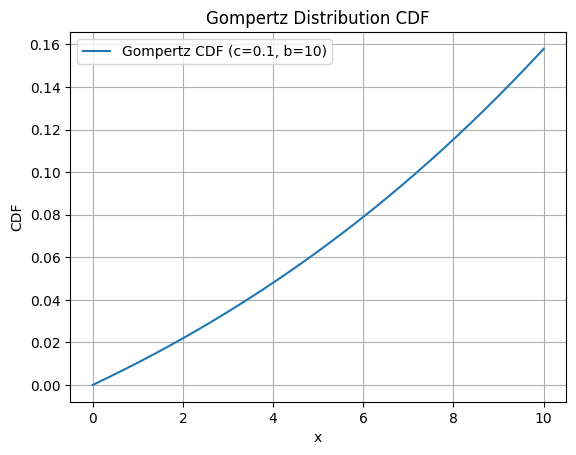

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gompertz

# Parameters of the Gompertz distribution
c = 0.1  # Shape parameter
b = 10 # Scale parameter

# Create a range of x values for plotting
x = np.linspace(0, 10, 500)

# Calculate the CDF values for the Gompertz distribution
cdf_values = gompertz.cdf(x, c, loc=0, scale=b)

# Plot the CDF
plt.plot(x, cdf_values, label=f'Gompertz CDF (c={c}, b={b})')
plt.title('Gompertz Distribution CDF')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sympy import symbols, Eq, solve, exp

def get_scale_param(mu_val):
    # Define symbols
    mu, s_new = symbols('mu s_new')

    # Define the modified CDF equation
    modified_cdf = 1 / (1 + exp(-(mu - mu) / s_new)) - 0.5

    # Solve for s_new to make the modified CDF zero at x = mu
    solution = solve(Eq(modified_cdf.subs(mu, mu_val), 0), s_new)

    return solution[0]  # Return the solution

# Parameters
mean = 50  # Mean of the logistic distribution
scale = get_scale_param(mean) 
# Scale parameter of the logistic distribution

# Generate data points for the positive range
x_positive = np.linspace(0, 100, 1000)

# Calculate the CDF (cumulative distribution function) of the logistic distribution
cdf_positive = logistic.cdf(x_positive, loc=mean, scale=scale)

# Plot the CDF for the positive domain
plt.figure(figsize=(8, 6))
plt.plot(x_positive, cdf_positive, label='Logistic Distribution CDF (Positive Domain)')
plt.axvline(x=mean, color='r', linestyle='--', label='Mean')
plt.xlabel('X')
plt.ylabel('Cumulative Probability')
plt.title('Logistic Distribution CDF (Positive Domain)')
plt.legend()
plt.grid(True)
plt.show()


IndexError: list index out of range

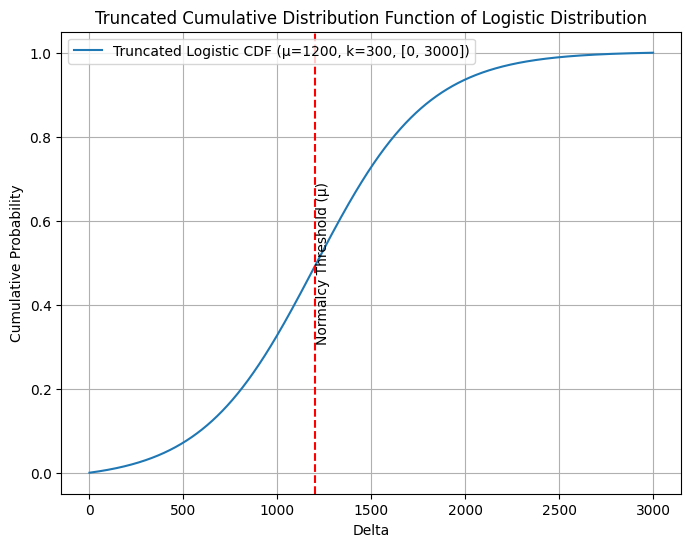

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the logistic distribution
mu = 1200   # Mean
k = 300    # Steepness parameter
a = 00    # Lower truncation limit
b = 3000   # Upper truncation limit

# Generate values for the x-axis within the truncated range
x_truncated = np.linspace(a, b, 5000)

# Calculate the truncated logistic CDF
cdf_truncated = (logistic.cdf(x_truncated, loc=mu, scale=k) -
                 logistic.cdf(a, loc=mu, scale=k)) / (logistic.cdf(b, loc=mu, scale=k) - logistic.cdf(a, loc=mu, scale=k))

# Plotting
plt.figure(figsize=(8, 6))

# Plot the truncated CDF
plt.plot(x_truncated, cdf_truncated, label=f'Truncated Logistic CDF (μ={mu}, k={k}, [{a}, {b}])')

plt.xlabel('Delta')
plt.ylabel('Cumulative Probability')
plt.title('Truncated Cumulative Distribution Function of Logistic Distribution')
plt.legend()
plt.axvline(x=mu, color='r', linestyle='--')
plt.text(mu + 5, 0.5, 'Normalcy Threshold (μ)', rotation=90, va='center')
plt.grid()
plt.show()


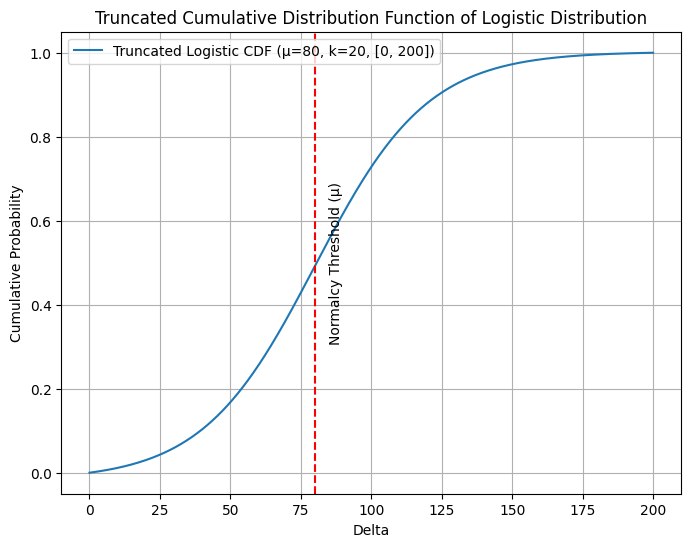

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the logistic distribution
mu = 80   # Mean
k = 20    # Steepness parameter
a = 0    # Lower truncation limit
b = 200   # Upper truncation limit

# Generate values for the x-axis within the truncated range
x_truncated = np.linspace(a, b, 5000)

# Calculate the truncated logistic CDF
cdf_truncated = (logistic.cdf(x_truncated, loc=mu, scale=k) -
                 logistic.cdf(a, loc=mu, scale=k)) / (logistic.cdf(b, loc=mu, scale=k) - logistic.cdf(a, loc=mu, scale=k))

# Plotting
plt.figure(figsize=(8, 6))

# Plot the truncated CDF
plt.plot(x_truncated, cdf_truncated, label=f'Truncated Logistic CDF (μ={mu}, k={k}, [{a}, {b}])')

plt.xlabel('Delta')
plt.ylabel('Cumulative Probability')
plt.title('Truncated Cumulative Distribution Function of Logistic Distribution')
plt.legend()
plt.axvline(x=mu, color='r', linestyle='--')
plt.text(mu + 5, 0.5, 'Normalcy Threshold (μ)', rotation=90, va='center')
plt.grid()
plt.show()


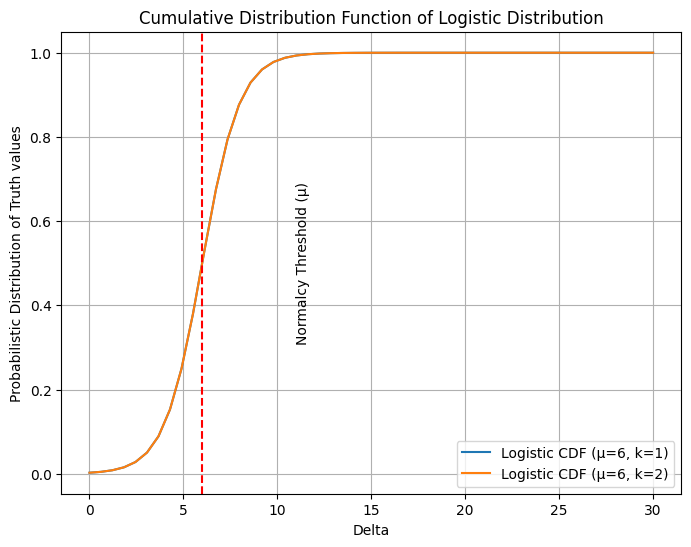

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the logistic distribution
mu = 6  # Mean
k = 1   # Steepness parameter

# Generate values for the x-axis
x = np.linspace(0, 30, 50)

# Calculate the logistic CDF
cdf = logistic.cdf(x, loc=mu, scale=k)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, cdf, label=f'Logistic CDF (μ={mu}, k={k})')
plt.plot(x, cdf, label=f'Logistic CDF (μ={mu}, k={2})')
plt.xlabel('Delta')
plt.ylabel('Probabilistic Distribution of Truth values')
plt.title('Cumulative Distribution Function of Logistic Distribution')
plt.legend()
plt.axvline(x=mu, color='r', linestyle='--')
plt.text(mu + 5, 0.5, 'Normalcy Threshold (μ)', rotation=90, va='center')
plt.grid()
plt.show()


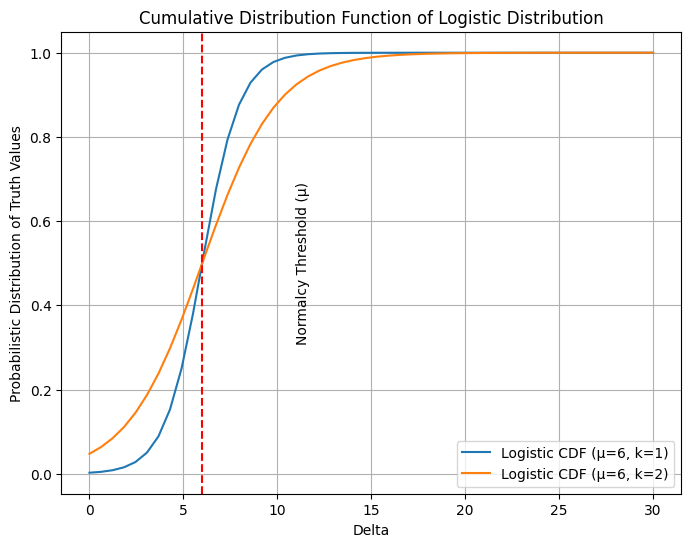

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# Parameters for the logistic distribution
mu = 6  # Mean
k = 1   # Steepness parameter

# Generate values for the x-axis
x = np.linspace(0, 30, 50)

# Calculate the logistic CDF for the first distribution
cdf1 = logistic.cdf(x, loc=mu, scale=k)

# Calculate the logistic CDF for the second distribution with k=2
k2 = 2  # New scale parameter
cdf2 = logistic.cdf(x, loc=mu, scale=k2)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, cdf1, label=f'Logistic CDF (μ={mu}, k={k})')
plt.plot(x, cdf2, label=f'Logistic CDF (μ={mu}, k={k2})')
plt.plot(x, cdf2, label=f'Logistic CDF (μ={mu}, k={k2})')

plt.xlabel('Delta')
plt.ylabel('Probabilistic Distribution of Truth Values')
plt.title('Cumulative Distribution Function of Logistic Distribution')
plt.legend()
plt.axvline(x=mu, color='r', linestyle='--')
plt.text(mu + 5, 0.5, 'Normalcy Threshold (μ)', rotation=90, va='center')
plt.grid()
plt.show()


In [10]:
import numpy as np
from scipy.stats import logistic

# Define the parameters of the logistic distribution
mu = 80  # Mean of the logistic distribution
k = 25   # Scale parameter of the logistic distribution

# Generate values for the x-axis
x = np.linspace(0, 300, 500)

# Choose a specific value of x for which you want to calculate the CDF value
specific_x = 8.56432  # Replace this with the value you're interested in

# Calculate the logistic CDF
cdf_values = logistic.cdf(x, loc=mu, scale=k)

# Find the index corresponding to the specific_x in the x array
index = np.argmin(np.abs(x - specific_x))

# Get the CDF value for the specific_x
specific_cdf_value = cdf_values[index]

print(f"CDF value for x = {specific_x}: {specific_cdf_value}")

assigned = random.choices([True, False], weights=[specific_cdf_value, 1-specific_cdf_value])[0]
print(f"Choice is: {assigned}")


CDF value for x = 8.56432: 0.05399651971099635
Choice is: False


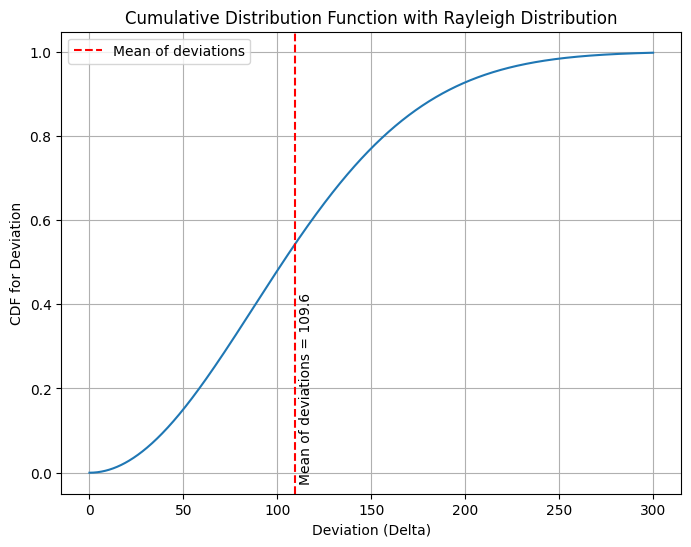

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values for plotting
x = np.linspace(0, 300, 1000)

plt.figure(figsize=(8, 6))

delta_sum = 0
for _ in range(100):
    delta_sum += np.random.randint(0, 200)

mu = delta_sum/100

sigma = mu / np.sqrt(np.pi / 2)
    
# Calculate the CDF values using the formula
cdf_values = 1 - np.exp(-x**2 / (2 * sigma**2))

# Plot the CDF
plt.plot(x, cdf_values)

plt.title('Cumulative Distribution Function with Rayleigh Distribution')
plt.xlabel('Deviation (Delta)')
plt.ylabel('CDF for Deviation')
# plt.legend()
plt.grid()
plt.axvline(x=mu, color='red', linestyle='--', label='Mean of deviations')
plt.text(mu + 1.8, 0.2, f'Mean of deviations = {mu}', color='black', rotation=90, verticalalignment='center')
plt.legend()
plt.show()
